In [24]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import Xception

In [25]:
def create_dataframe(folder_path):
    data = {'image_path': [], 'labels': []}

    # Klasörleri dön
    for class_folder in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_folder)

        # Eğer bir dizinse devam et, değilse atla
        if os.path.isdir(class_folder_path):
            # Sınıf klasörünü dön
            for image_file in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_file)

                # Etiketi al (sınıf ismi)
                labels = class_folder

                # Dataframe'e ekle
                data['image_path'].append(image_path)
                data['labels'].append(labels)

    # Pandas dataframe oluştur
    df = pd.DataFrame(data)
    return df
    


# Veri setinin bulunduğu ana klasör yolu
dataset_path = './'

# Train, test ve val için ayrı ayrı dataframe'leri oluştur
train_df = create_dataframe(os.path.join(dataset_path, 'train'))
test_df = create_dataframe(os.path.join(dataset_path, 'test'))
valid_df = create_dataframe(os.path.join(dataset_path, 'val'))


In [26]:
all_df = pd.concat([train_df, test_df, valid_df], ignore_index=True)
all_df

,image_path,labels
0,./train\aloevera\aloevera0.jpg,aloevera
1,./train\aloevera\aloevera1.jpg,aloevera
2,./train\aloevera\aloevera10.jpg,aloevera
3,./train\aloevera\aloevera100.jpg,aloevera
4,./train\aloevera\aloevera101.jpg,aloevera
...,...,...
29995,./val\watermelon\watermelon795.jpg,watermelon
29996,./val\watermelon\watermelon796.jpg,watermelon
29997,./val\watermelon\watermelon797.jpg,watermelon
29998,./val\watermelon\watermelon798.jpg,watermelon


In [27]:
ds_name = 'Plant Classification'

In [28]:
def num_of_examples(all_df, name='df'):
    print(f"{name} The dataset has {all_df.shape[0]} images.")
    
num_of_examples(all_df, ds_name)

Plant Classification The dataset has 30000 images.


In [29]:
def num_of_classes(all_df, name='df'):
    print(f"{name} in the data set {len(all_df['labels'].unique())} there is class.")
    
num_of_classes(all_df, ds_name)

Plant Classification in the data set 30 there is class.


In [30]:
def classes_count(all_df, name='df'):
    
    print(f"{name} veri setinde: ")
    print("="*70)
    print()
    for name in all_df['labels'].unique():
        num_class = len(all_df['labels'][all_df['labels'] == name])
        print(f"'{name}' class {num_class} It has 1 image. ")
        print('-'*70)
        
classes_count(all_df, ds_name)

Plant Classification veri setinde: 

'aloevera' class 1000 It has 1 image. 
----------------------------------------------------------------------
'banana' class 1000 It has 1 image. 
----------------------------------------------------------------------
'bilimbi' class 1000 It has 1 image. 
----------------------------------------------------------------------
'cantaloupe' class 1000 It has 1 image. 
----------------------------------------------------------------------
'cassava' class 1000 It has 1 image. 
----------------------------------------------------------------------
'coconut' class 1000 It has 1 image. 
----------------------------------------------------------------------
'corn' class 1000 It has 1 image. 
----------------------------------------------------------------------
'cucumber' class 1000 It has 1 image. 
----------------------------------------------------------------------
'curcuma' class 1000 It has 1 image. 
----------------------------------------------------

In [31]:
def cat_summary_with_graph(dataframe, col_name):
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
              '#1a1a1a', '#ff69b4', '#ffd700', '#008000', '#4b0082',
              '#e6e6fa', '#ff4500', '#8b4513', '#00ced1', '#dda0dd',
              '#bdb76b', '#7fffd4', '#8a2be2', '#ff8c00', '#9932cc',
              '#ff1493', '#00fa9a', '#8b0000', '#008b8b', '#483d8b']

    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentage Chart'),
                        specs=[[{"type": "bar"}, {'type': 'pie'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=20),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors)),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)

# Örnek kullanım
cat_summary_with_graph(all_df, 'labels')

In [32]:
def check_null_values(all_df, name='df'):
    
    num_null_vals = sum(all_df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"{name} There are no null values ​​in the data set.")
    
    else:
        print(f"The {name} dataset has {num_null_vals} null values.")
        print('-'*70)
        print('Total null values ​​in each column:\n')
        print(all_df.isnull().sum())
        

check_null_values(all_df, ds_name)

Plant Classification There are no null values ​​in the data set.


In [33]:
batch_size = 40
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

#Test veri setinin üzerinde modelin tahminlerini değerlendirmek üzere uygun bir batch_size ve adım sayısını belirlemek amacıyla kullanılmıştır.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size


# Undefined hatası almamak için tanımlanıyor scalar fonksiyonu.
# scalar:her bir görüntü üzerinde uygulanacak olan özel bir ölçekleme (scaling) fonksiyonunu temsil eder.(Burada bir işlev tanımlanmamıştır).
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function=scalar)

ts_gen = ImageDataGenerator(preprocessing_function=scalar)


train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col = 'image_path', 
                                       y_col= 'labels', 
                                       target_size = img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'image_path', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'image_path', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 21000 validated image filenames belonging to 30 classes.
Found 3000 validated image filenames belonging to 30 classes.
Found 6000 validated image filenames belonging to 30 classes.


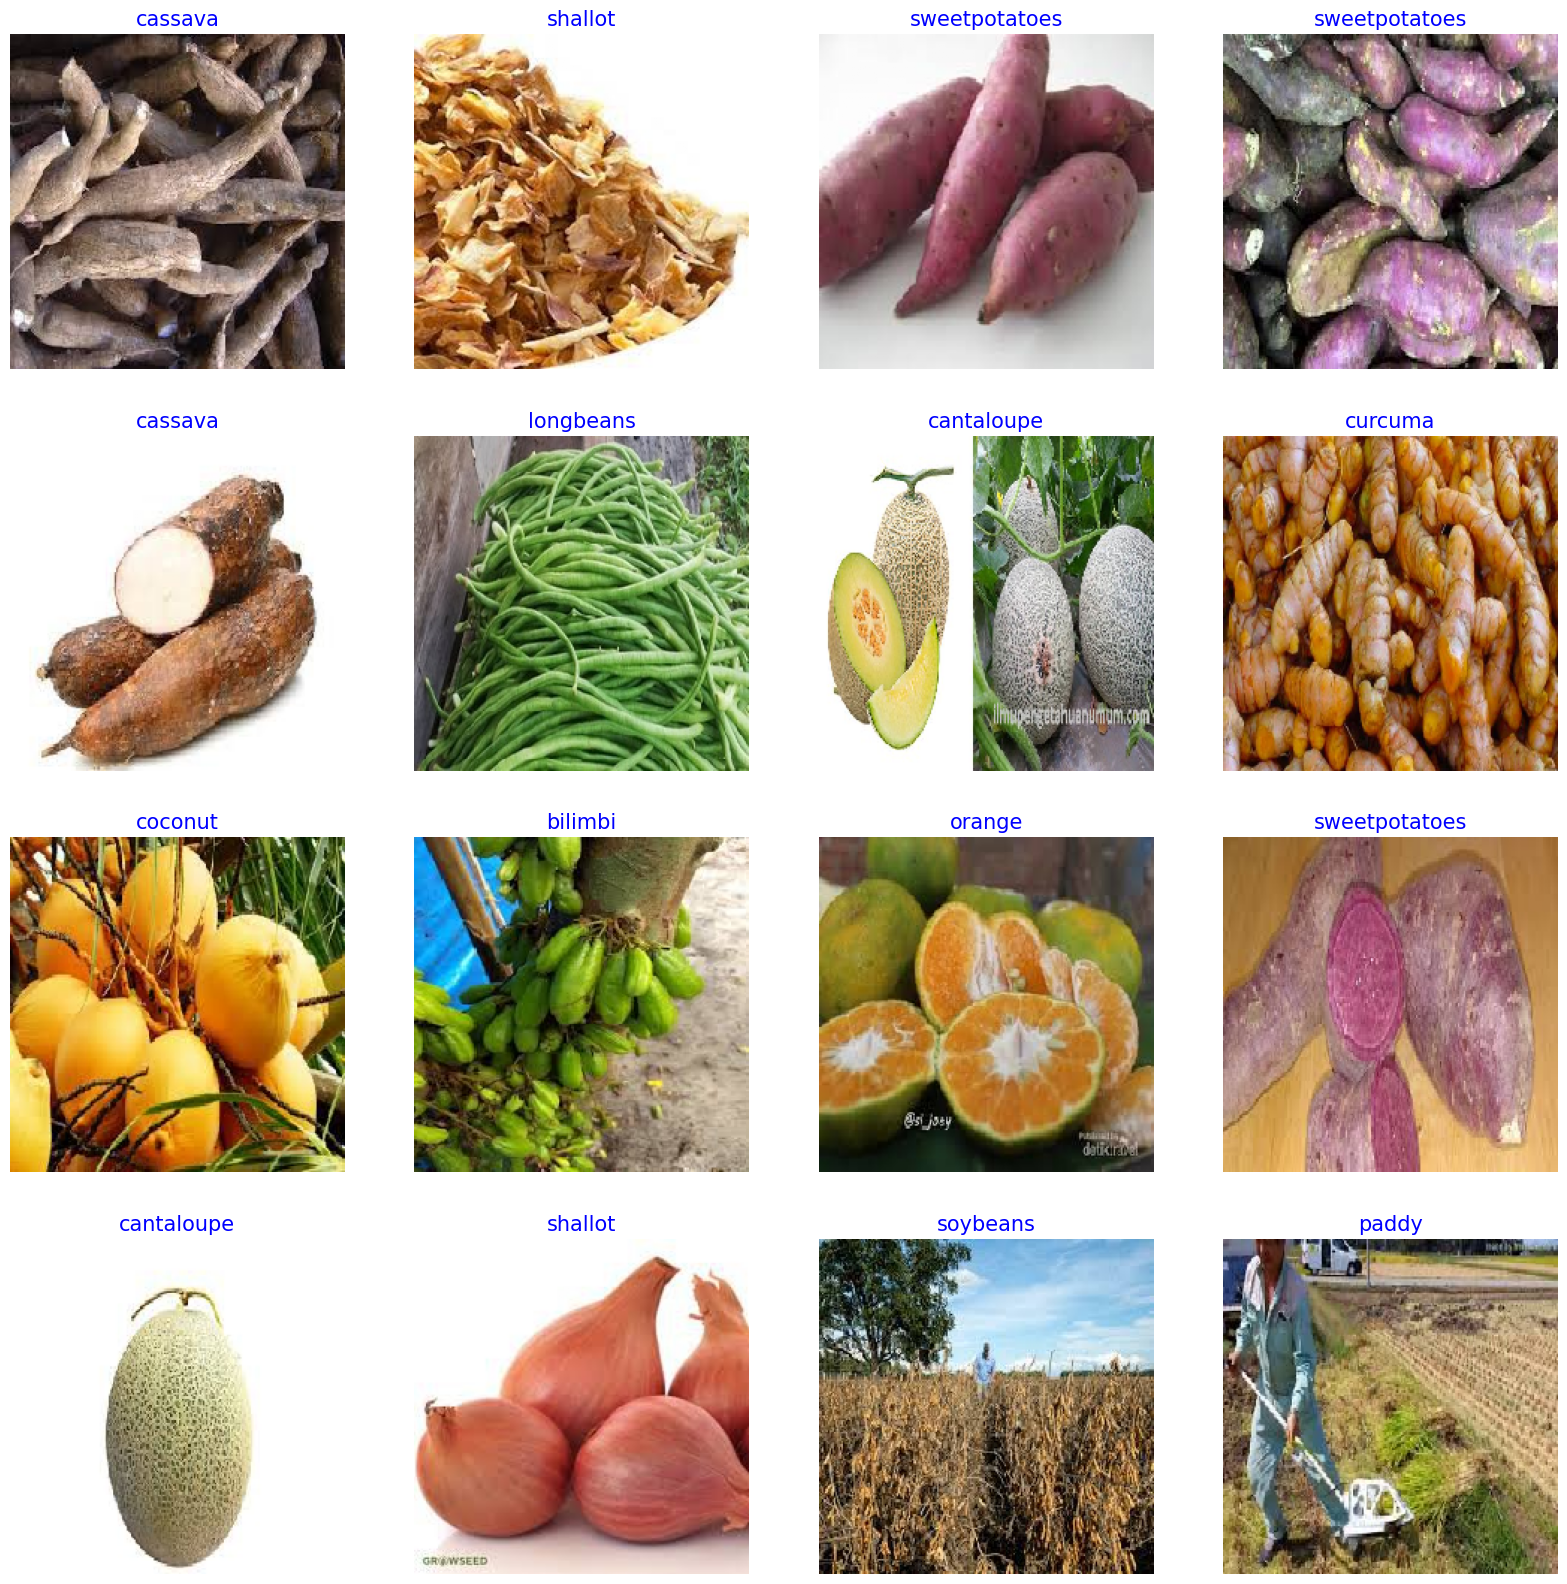

In [34]:
g_dict = train_gen.class_indices  

# Sınıf adlarını içeren bir liste oluşturulur.
classes = list(g_dict.keys())       

# Eğitim veri üretecinin bir grup örneğini alınır.
images, labels = next(train_gen)      

# 20x20 büyüklüğünde bir çizim figürü oluşturulur.
plt.figure(figsize=(20, 20))  

# 16 örnek için bir döngü başlatılır.
for i in range(16):
    
    # 4x4'lük bir alt-çizim oluşturulur.
    plt.subplot(4, 4, i + 1)  
    
    # Görüntü, 0 ile 255 arasında değerler içeren bir dizi olarak normalleştirilir.
    image = images[i] / 255       
   
    # Normalleştirilmiş görüntü, alt-çizimde gösterilir.
    plt.imshow(image)  
    
    # Etiket dizisindeki en büyük değerin (1'e karşılık gelen) indeksi alınır.
    index = np.argmax(labels[i])  
    
    # İndise karşılık gelen sınıf adı alınır.
    class_name = classes[index]   
    
    # Alt-çizimin başlığı, sınıf adı olarak ayarlanır ve mavi renkte gösterilir.
    plt.title(class_name, color='blue', fontsize=15)  
    
    # Eksenler kapatılır, yani alt-çizimdeki koordinat ekseni gösterilmez.
    plt.axis('off')  
    
# Oluşturulan tüm alt-çizimleri içeren genel çizim gösterilir.
plt.show()  

In [35]:
# Giriş görüntü boyutları
img_size = (224, 224)

# Görüntü kanal sayısı (RGB için 3)
channels = 3

# Giriş görüntü şekli
img_shape = (img_size[0], img_size[1], channels)

# Modelin çıktı sınıf sayısını belirlemek için eğitim veri üreticisinin sınıf sayısı
class_count = len(list(train_gen.class_indices.keys()))

#EfficientNetB7 modeli yapılandırılır.
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Önceden eğitilmiş modelin eğitilebilirliğini kapatma
base_model.trainable = False

# Yeni modelin oluşturulması
model = Sequential([
    base_model,  # Önceden eğitilmiş model
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Batch normalization katmanı
    Dense(128, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
      bias_regularizer=regularizers.l1(0.006), activation='relu'),  # Yoğun (Dense) katman
    Dropout(rate=0.3, seed=123),   # Dropout katmanı
    Dense(class_count, activation='softmax')  # Çıkış katmanı
])

# Modelin derlenmesi
model.compile(Adamax(learning_rate=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özetini görüntüleme
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ ?                      │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 64,097,687 (244.51 MB)

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True,
                               mode='min',
                              )

In [38]:
batch_size = 64 # Eğitim için toplu boyutu ayarla(set batch size for training)
epochs = 30   # Eğitimdeki Toplam Epoch Sayısı

history = model.fit(x=train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen, 
                    validation_steps = None,
                    shuffle = False,
                    batch_size = batch_size,
                    callbacks = [early_stopping])

Epoch 1/30


C:\Users\tripm\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



432/525 ━━━━━━━━━━━━━━━━━━━━ 6:51 4s/step - accuracy: 0.1022 - loss: 9.4762